In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression as lin 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet as en 
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import GradientBoostingRegressor as gb
from sklearn.ensemble import ExtraTreesRegressor as et
from sklearn.ensemble import HistGradientBoostingRegressor as hist
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor as dt
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import func_generation as fg
import coefficient_estimators as ce
import model_eval


In [2]:

critical_vars = {0:[0.5,4], 1:[0.5,3,4,20]}
funcs_dict= {(0,0):[1,7,-13,4,50,0,0],(1,0):[3,4,3,0,3,0,0],(2,0):[3,10,3,-8,0,0,4],(0,1):[5,-3,3,0,-5,0,0],(0,2):[12,14,3,0,-4,0,-6],(0,3):[1,4,34,0,-4,0,6],(2,3):[-1,-4,34,0,-4,0,6],(1,4):[-1,-4,34,0,0,0,0],(1,3):[-1,20,6,0,6,0,0]}


#piecewise(data[:,:-1], funcs_dict, critical_vars, default_coeffs=[-1,-10,3,2,0])



In [7]:
verbose = True
resy=dict()

models = [
        lin(),
        Ridge(alpha=2),
        Lasso(alpha=2),
        #en(),
        #rf(n_estimators=1000, max_features=None),
        rf(max_features=None),
        # rf(n_estimators=1000),
        # rf()
        # gb(),
        # et(),
        dt()
    ]
for i in models:
    resy[str(i)]=list()

size=5000
for _ in range(1):

    a = np.random.exponential(scale = 3, size=size)
    b = np.random.exponential(scale = 6, size=size)
    c = np.clip(a+np.random.normal(0,4,size), 0, a_max=np.inf)
    d = np.random.normal(0,10,size)
    e = d+np.random.normal(0,10,size)
    f = np.clip(a+np.random.normal(0,4,size), 0, a_max=np.inf)
    g = np.clip(f+np.random.normal(0,4,size), 0, a_max=np.inf)
    data = pd.DataFrame({'a':a,'b':b,'c':c,'d':d,'e':e,'f':f,'g':g}).to_numpy()

    func_coeffs = [
        (4,0),
        (0,0),
        (-1,0),
        (4,0),
        (0,0),
    ]

    default_coefs = [-1,-10,3,4,5,0,0]

    #get coefficients in proper format
    coeffs = fg.generate_function_coefficients(func_coeffs, n=1)

    #generate noise
    noise=np.random.normal(0,4, size=size)

    #generate function output
    #y = (generate_func_output(coeffs, data, 0)+noise).reshape(-1,1)
    y, util_dict = fg.piecewise(data, funcs_dict, critical_vars, default_coefs)
    y=y+noise
    y=y.reshape(-1,1)

    data = np.concatenate((data,y), axis=1)

    if verbose:
        print(f' data is of shape {data.shape}')
        print('\n')

        print('Coefficient Utilization')
        for key, value in util_dict.items():

            print(f'{key}: {value}')


    train=data[:int(size/2)]
    test=data[int(size/2):]

    
    #print corr matrix of variables
    if verbose:
        print('Correlation matrix')
        print(pd.DataFrame(data).corr())
        print('\n')
        print('\n')

    #train models and report TEST RMSE
    res = fg.bake_off_func_output(train,test,models,[model_eval.rmse])

    if verbose: 
        print('Models and Test Errors')

        for key, value in res.items():

            print(f'{key}: {value}')

        print('\n')
        print('\n')


    #gather the trained on coefficients for now
    observed_coef = fg.weighted_coefs_from_util(funcs_dict, util_dict,default_coefs)

    #print(models)
    #grab all coefficient estimates
    feature_means = ce.get_feature_means_models(train[:,:-1],models)
    #print(models)
    estimates = ce.get_coef_estimates(train[:,:-1], models, feature_means)

    ranks_by_coef_error = model_eval.rank_by_coef_error(estimates, observed_coef)

    print(f'estimate: {estimates}')
    print(f'observed: {observed_coef}')

    if verbose: print('Cosine Sim errors for func weights')

    for key, value in ranks_by_coef_error.items():

        if verbose: print(f'{key}: {value}')
        
        #resy[str(key)].append(value)

    

 data is of shape (5000, 8)


Coefficient Utilization
default: 1791
(0, 0): 58
(1, 0): 230
(2, 0): 124
(0, 1): 228
(0, 2): 78
(0, 3): 364
(2, 3): 659
(1, 4): 99
(1, 3): 1369
Correlation matrix
          0         1         2         3         4         5         6  \
0  1.000000 -0.024507  0.630499  0.009889  0.018751  0.645532  0.494103   
1 -0.024507  1.000000 -0.025140  0.039494  0.029430 -0.014502 -0.029754   
2  0.630499 -0.025140  1.000000  0.011781  0.016666  0.418589  0.322332   
3  0.009889  0.039494  0.011781  1.000000  0.694125  0.002966 -0.001862   
4  0.018751  0.029430  0.016666  0.694125  1.000000  0.017331  0.017348   
5  0.645532 -0.014502  0.418589  0.002966  0.017331  1.000000  0.745165   
6  0.494103 -0.029754  0.322332 -0.001862  0.017348  0.745165  1.000000   
7  0.165413  0.215732  0.266225  0.231083  0.308279  0.122139  0.108229   

          7  
0  0.165413  
1  0.215732  
2  0.266225  
3  0.231083  
4  0.308279  
5  0.122139  
6  0.108229  
7  1.000000  




M

In [5]:
np.array(feature_means).shape

(1, 99, 7)

In [383]:
for key, value in resy.items():
    print(f'{key}: {np.mean(value)}')

LinearRegression(): 0.5166257490563712
Ridge(): 0.51759238489142
Lasso(): 0.5205017393887682
ElasticNet(): 0.5382741861160308
RandomForestRegressor(max_features=None, n_estimators=1000): 0.2018296954035377
RandomForestRegressor(max_features=None): 0.20724391025695393
RandomForestRegressor(n_estimators=1000): 0.20248337282874002
RandomForestRegressor(): 0.21065671369698927


In [385]:
size=100
verbose=True

a = np.random.exponential(scale = 3, size=size)
b = np.random.exponential(scale = 6, size=size)
c = np.clip(a+np.random.normal(0,4,size), 0, a_max=np.inf)
d = np.random.normal(0,10,size)
e = d+np.random.normal(0,10,size)
f = np.clip(a+np.random.normal(0,4,size), 0, a_max=np.inf)
g = np.clip(f+np.random.normal(0,4,size), 0, a_max=np.inf)
data = pd.DataFrame({'a':a,'b':b,'c':c,'d':d,'e':e,'f':f,'g':g}).to_numpy()

func_coeffs = [
    (4,0),
    (0,0),
    (-1,0),
    (4,0),
    (0,0),
]

models = [
        lin(),
        Ridge(),
        Lasso(),
        en(),
        rf(n_estimators=1000, max_features=None),
        rf(max_features=None),
        rf(n_estimators=1000),
        rf()
        # gb(),
        # et(),
        # dt()
    ]

default_coefs = [-1,-10,3,4,5,0,0]

#get coefficients in proper format
coeffs = generate_function_coefficients(func_coeffs, n=1)

#generate noise
noise=np.random.normal(0,4, size=size)

#generate function output
#y = (generate_func_output(coeffs, data, 0)+noise).reshape(-1,1)
y, util_dict = piecewise(data, funcs_dict, critical_vars, default_coefs)
y=y+noise
y=y.reshape(-1,1)

data = np.concatenate((data,y), axis=1)

if verbose:
    print(f' data is of shape {data.shape}')
    print('\n')

    print('Coefficient Utilization')
    for key, value in util_dict.items():

        print(f'{key}: {value}')


train=data[:int(size/2)]
test=data[int(size/2):]


#print corr matrix of variables
if verbose:
    print('Correlation matrix')
    print(pd.DataFrame(data).corr())
    print('\n')
    print('\n')

#train models and report TEST RMSE
res = bake_off_func_output(train,test,models,[rmse])

if verbose: 
    print('Models and Test Errors')

    for key, value in res.items():

        print(f'{key}: {value}')

    print('\n')
    print('\n')


#gather the trained on coefficients for now
observed_coef = weighted_coefs_from_util(funcs_dict, util_dict,default_coefs)

#grab all coefficient estimates
feature_means = np.mean(train[:,:-1], axis=0)
estimates = get_coef_estimates(models, train, feature_means )

ranks_by_coef_error = rank_by_coef_error(estimates, observed_coef)

if verbose: print('Cosine Sim errors for func weights')

for key, value in ranks_by_coef_error.items():

    if verbose: print(f'{key}: {value}')

 data is of shape (100, 8)


Coefficient Utilization
default: 43
(0, 0): 1
(1, 0): 7
(2, 0): 2
(0, 1): 7
(0, 2): 1
(0, 3): 2
(2, 3): 6
(1, 4): 4
(1, 3): 27
Correlation matrix
          0         1         2         3         4         5         6  \
0  1.000000  0.111596  0.675392  0.098353  0.164418  0.653901  0.406823   
1  0.111596  1.000000  0.045759 -0.012270  0.093794 -0.025221 -0.156602   
2  0.675392  0.045759  1.000000  0.078853  0.212708  0.362923  0.239435   
3  0.098353 -0.012270  0.078853  1.000000  0.824297  0.067047  0.084725   
4  0.164418  0.093794  0.212708  0.824297  1.000000  0.157981  0.112422   
5  0.653901 -0.025221  0.362923  0.067047  0.157981  1.000000  0.704991   
6  0.406823 -0.156602  0.239435  0.084725  0.112422  0.704991  1.000000   
7  0.043863  0.041283  0.127570  0.435123  0.502476  0.066491  0.029511   

          7  
0  0.043863  
1  0.041283  
2  0.127570  
3  0.435123  
4  0.502476  
5  0.066491  
6  0.029511  
7  1.000000  




Models and Test Err

In [384]:
estimates

{LinearRegression(): array([-13.5635079 ,   0.81396731,   3.16846107,   4.35774837,
          3.74874763,  -1.75313207,   6.17989678]),
 Ridge(): array([-13.42859232,   0.80773629,   3.10194182,   4.3509204 ,
          3.75337845,  -1.74545741,   6.1514181 ]),
 Lasso(): array([-12.95488096,   0.73980043,   2.67166559,   4.33377087,
          3.7598681 ,  -1.37429228,   5.88860142]),
 ElasticNet(): array([-10.64469519,   0.65893165,   1.68164375,   4.2076762 ,
          3.84254661,  -1.39872351,   5.44682607]),
 RandomForestRegressor(max_features=None, n_estimators=1000): array([  5.82659678,  15.24533603,   1.77325261,  -7.66889833,
          3.09664859, -16.78453457,  -0.60022802]),
 RandomForestRegressor(max_features=None): array([  6.72017138,  14.69726562,   1.44936468, -12.64977264,
          2.63806733, -15.97540563,   2.04529333]),
 RandomForestRegressor(n_estimators=1000): array([  7.345778  ,  15.00337558,   2.80281517,  -6.69556578,
          3.17955892, -17.72066521,   2.177

In [386]:
observed_coef

array([-0.03,  1.26,  7.37,  1.6 ,  3.77,  0.  ,  0.5 ])

In [390]:
np.nanmean(np.array([np.nan, 1,2]))

1.5

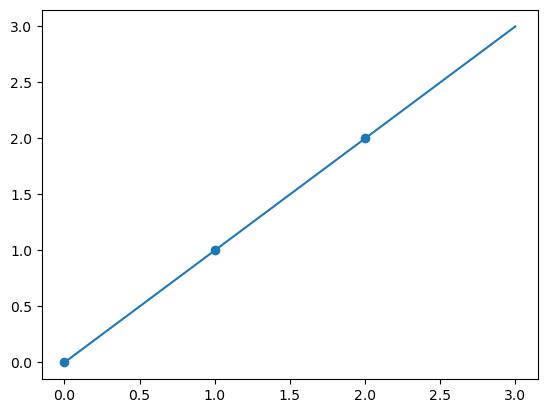

In [254]:
#strategies to try next (what is the local mean of feature)
#sub gloabl mean value for each feature and run preds

In [409]:
mod.coef_

array([[0.64285714]])

-0.0010044934116021365
7.076805691825904


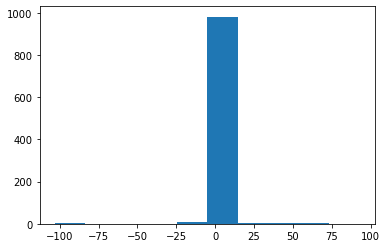

In [11]:
m = 2#mod.coef_[0]
res_ = list()

for _ in range(1000):
    n=100

    x = np.random.normal(0,10,size=n)
    #x2 = x+ np.random.normal(6,2,size=n)

    #this is the mean of y
    mean = 0
    for i in range(n):

        mean+= m*x[i] 

    mean=mean/n

    res=0
    for i in range(n):

        y=m*x[i]+np.random.normal(0,2)

        if x[i]!=np.mean(x):
            res+=((y-mean)/(x[i]-np.mean(x)))/n
            
    res_.append(res-m)

plt.hist(res_)

print(np.median(res_))
print(np.std(res_))



-0.07172595131475457
1.3877787807814457e-17


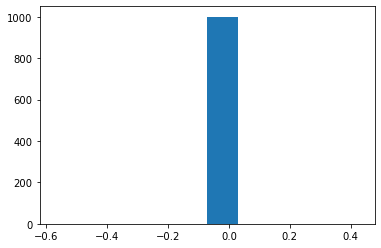

1.899968819664278
26.658347703721393


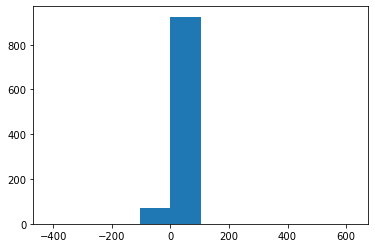

In [13]:
#now add in x2 as noise

m = 2#mod.coef_[0]
m2=0
res_ = list()
res2_=list()

mod1=lin()
mod2=lin()

for _ in range(1000):
    n=100

    x = np.random.normal(0,10,size=n)
    x2 = x+ np.random.normal(6,2,size=n)

    # x_given_x2 = mod1.fit(x2,x)
    # x2_given_x = mod2.fit(x,x2)

    #this is the mean of y
    mean = 0
    for i in range(n):

        mean+= m*x[i] 

    mean=mean/n

    res_1=0
    res_2=0
    for i in range(n):

        #x2 is just correlated but does not affect outcome
        y=m*x[i] + m2*x2[i] + np.random.normal(0,2)

        if x[i]!=np.mean(x):
            res_1+=((y-mean)/(x[i]-np.mean(x)))/n
        
        if x2[i]!=np.mean(x2):
            res_2+=((y-mean)/(x2[i]-np.mean(x2)))/n
            
    res_.append(res-m)
    res2_.append(res_2-m2)

for item in [res_, res2_]:
    plt.hist(item)
    print(np.median(item))
    print(np.std(item))
    plt.show()

-0.07172595131475457
1.3877787807814457e-17


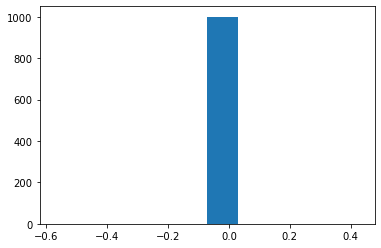

-1.0903028352501296
794.4903532586179


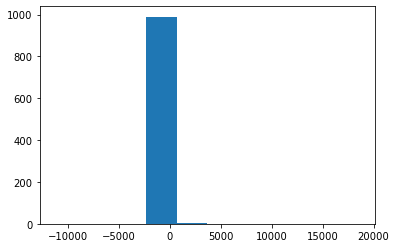

-0.0054803036904070845
0.5294686024991465


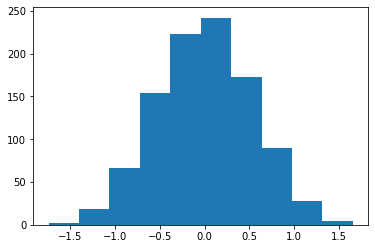

-0.011504776817684248
0.5222783744958766


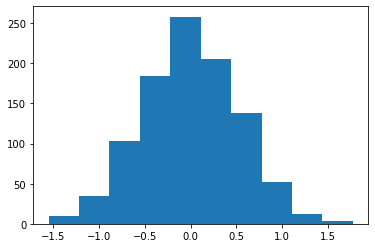

In [41]:
#now add in x2 as noise

m = 2#mod.coef_[0]
m2=1
res_ = list()
res2_=list()
rres=list()
rres2=list()

mod1=lin()
mod2=lin()

for _ in range(1000):
    n=100

    x = np.random.normal(0,10,size=n)
    x2 = x+ np.random.normal(6,2,size=n)
    y=m*x + m2*x2 + np.random.normal(0,2, size=len(x))

    #variable estimation models
    x_given_x2 = mod1.fit(x2.reshape(-1,1),x.reshape(-1,1))
    x2_given_x = mod2.fit(x.reshape(-1,1),x2.reshape(-1,1))

    #fit ridge to compare result
    ridgeMod = Ridge(alpha=1)
    model_data=np.array([[x[i],x2[i]] for i in range(len(x))])
    ridgeMod.fit(model_data, (y+np.random.normal(0,10,size=len(y))).reshape(-1,1))
    #print(ridgeMod.coef_)

    res_1=0
    res_2=0
    for i in range(n):

        if x[i]!=np.mean(x):
            res_1+=((y[i]-np.mean(y))/(x[i]-x_given_x2.predict([[x2[i]]])[0][0]))/n
        
        if x2[i]!=np.mean(x2):
            res_2+=((y[i]-np.mean(y))/(x2[i]-x2_given_x.predict([[x[i]]])[0][0]))/n
            
    res_.append(res-m)
    res2_.append(res_2-m2)

    rres.append(ridgeMod.coef_[0][0]-m)
    rres2.append(ridgeMod.coef_[0][1]-m2)

for item in [res_, res2_,rres,rres2]:
    plt.hist(item)
    print(np.median(item))
    print(np.std(item))
    plt.show()

In [30]:
dir(ridgeMod)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_data',
 '_validate_params',
 'alpha',
 'coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_features_in_',
 'n_iter_',
 'positive',
 'predict',
 'random_state',
 'score',
 'set_params',
 'solver',
 'tol']

In [392]:
for key,value in estimates.items():
    print(value.reshape(1,-1))
    print(observed_coef.reshape(1,-1))
    print(cosine_similarity(value.reshape(1,-1),observed_coef.reshape(1,-1)))

[[-18.47810026  -1.86502508  10.84982534   2.0127673    4.45834194
   -4.40021779   3.4344017 ]]
[[-0.03  1.26  7.37  1.6   3.77  0.    0.5 ]]
[[0.51419328]]
[[-18.27726868  -1.87236067  10.7392478    1.99369214   4.47071529
   -4.4412127    3.42096406]]
[[-0.03  1.26  7.37  1.6   3.77  0.    0.5 ]]
[[0.51468144]]
[[-17.98922376  -1.87769419  10.48915377   1.95471514   4.48916086
   -4.25680378   3.25969448]]
[[-0.03  1.26  7.37  1.6   3.77  0.    0.5 ]]
[[0.51403939]]
[[-14.4194489   -2.00973752   8.51484369   1.63238758   4.69791798
   -4.93652988   3.00015284]]
[[-0.03  1.26  7.37  1.6   3.77  0.    0.5 ]]
[[0.52181402]]
[[-19.25168231 -32.63998274   5.95273629  -0.53573721 -19.30788771
   17.29946705  -3.49444722]]
[[-0.03  1.26  7.37  1.6   3.77  0.    0.5 ]]
[[-0.18175922]]
[[-24.4365367  -45.47780769   5.33582727  -0.31328042  -9.49358576
   19.79678792  -5.04068401]]
[[-0.03  1.26  7.37  1.6   3.77  0.    0.5 ]]
[[-0.11601305]]
[[-16.99859501 -37.26719568   6.17709693  -0.76784

In [423]:
#todo: calcualte average params from util dict and create function to calculate distance from esimtated params by model






def create_feature_response_means(tree, data):
    """
    create feature and response means for all nodes in a way that mirrors the structure of 
    children left object within each tree

    data must include y (response variable) as rightmost column
    """
    #need to create an empty array to store means
    #dimensions n_nodes*d_features
    empty = np.zeros((len(tree.children_left),data.shape[0]))

    #
    empty[0] = np.nanmean(data, axis=0)








In [425]:
a=np.array([[1,2,3],[1,2,3]])

np.mean(a, axis=0)

array([1., 2., 3.])

In [424]:
models[-1].estimators_[0].tree_.children_left

array([ 1,  2,  3, -1,  5, -1, -1,  8,  9, 10, -1, 12, 13, 14, -1, -1, -1,
       18, -1, -1, 21, -1, -1, -1, 25, 26, 27, 28, 29, 30, -1, 32, -1, -1,
       35, 36, 37, -1, -1, -1, 41, -1, -1, -1, 45, -1, -1, 48, 49, -1, -1,
       52, 53, 54, -1, -1, -1, 58, -1, 60, 61, -1, -1, 64, -1, -1, -1],
      dtype=int64)

In [177]:
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree
# plt.figure(figsize=(10,15))
# a = plot_tree(models[-1])

    

In [26]:
import numpy as np
l1 = [1,1,0]
l2 = [1,1,1,0,0]

tot = 0
l1_ = 0
seen = 0
for i in range(100000):

    lit = np.random.choice([0,1])

    if lit==0:
        pup = np.random.choice(l1)
        tot += pup

        if pup==0:
            l1_+=1
            seen+=1

    else:
        pup = np.random.choice(l2)
        tot+=pup

        if pup==0:
            seen+=1

print(tot/100000)
print(l1_/seen)


0.63354
0.4527642853244556


In [401]:
dir(models[-1].estimators_[0].tree_)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'apply',
 'capacity',
 'children_left',
 'children_right',
 'compute_feature_importances',
 'compute_node_depths',
 'compute_partial_dependence',
 'decision_path',
 'feature',
 'impurity',
 'max_depth',
 'max_n_classes',
 'missing_go_to_left',
 'n_classes',
 'n_features',
 'n_leaves',
 'n_node_samples',
 'n_outputs',
 'node_count',
 'predict',
 'threshold',
 'value',
 'weighted_n_node_samples']

In [27]:
g100=0
for _ in range(10000):

    unc=0
    for i in range(2000):

        a=np.random.choice([0,1], p=[0.01,0.99])

        if a==0:
            unc+=1
    if unc>99:
        g100+=1

print(g100/10000)

0.0


In [421]:

sigs=0
for i in range(100000):

    for j in range(5):

        sig = np.random.choice([0,1],p=[0.99,0.01])

        if sig==1:
            sigs+=1
            break
print(sigs)

4908
